# *Alright here's the plan: import the datasets, trim the fat, organize the columns, and add some features.*

In [ ]:
### libraries ###
import pandas as pd
import numpy as np
import gzip
import os.path
from os import path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from scipy.stats import norm
import scipy as scipy

### basically "if this file doesn't already exist, go get it." ###
if path.exists('title.basics.tsv.gz') == True:
  None
else:
  !wget https://datasets.imdbws.com/title.basics.tsv.gz
  !wget https://datasets.imdbws.com/title.ratings.tsv.gz
### these are the datasets I'll need from IMDB ###

### unzipping the downloaded IMDB datasets ###
with gzip.open('title.basics.tsv.gz') as f:
  basics = pd.read_csv(f, sep='\t')

with gzip.open('title.ratings.tsv.gz') as s:
  ratings = pd.read_csv(s, sep='\t')

### dropping what I don't need ###
imdb = basics.drop(['isAdult', 'endYear', 'runtimeMinutes', 'originalTitle'], axis=1)
imdb = imdb[imdb['titleType'] != 'tvEpisode']
imdb = imdb[imdb['titleType'] != 'short']
imdb = imdb[imdb['titleType'] != 'video']
imdb = imdb[imdb['titleType'] != 'tvSeries']
imdb = imdb[imdb['titleType'] != 'tvMiniSeries']
imdb = imdb[imdb['titleType'] != 'videoGame']
imdb.drop(imdb[imdb['startYear'] == '\\N'].index, inplace = True)
imdb['startYear'] = imdb['startYear'].astype('int32')
imdb.drop(imdb[imdb['startYear'] < 1937].index, inplace = True)
ratings = ratings.drop('numVotes', axis=1)

### merging the two datasets using IMDB's unique identifier ###
imdb = imdb.merge(ratings, left_on='tconst', right_on='tconst')

### reading in a dataset I found for Metacritic reviews ###
meta = pd.read_csv('https://raw.githubusercontent.com/collinjensen/csvs/main/metacritic_movies.csv')
### dropping what I don't need ###
meta = meta.drop(['release_date',
                 'genre',
                 'meta_mixed',
                 'meta_negative',
                 'meta_positive',
                 'user_mixed',
                 'user_negative',
                 'user_positive'], axis=1)

### merging the new IMDB dataset (combination of two) with the Metacritic one ###
imdb_meta = pd.merge(imdb, meta, how='left', left_on=['primaryTitle'], right_on=['movie_title'])
imdb_meta = imdb_meta.drop_duplicates(subset=['tconst'])
### whoever created the Metacritic dataset was nice enough to use the same titles as IMDB
### nice ###

### importing the csv of all movies I've seen ###
seen = pd.read_csv('https://raw.githubusercontent.com/collinjensen/csvs/main/Every%20movie%20Collin%20has%20scene%20-%20Sheet1.csv')
### dropping some stuff ###
seen = seen.drop(['Rating', 'Sequel?', 'Runtime (minutes)', 'Total # of Movies:', '668', 'Unnamed: 0'], axis=1)

### merging the combo IMDB/Metacritic dataset with the dataset of movies I've seen ###
bfdf = pd.merge(seen, imdb_meta, how='left', left_on=['Released', 'Title'], right_on=['startYear', 'primaryTitle'])
### starting the merge on release year, then movie title ###
### "big fucking dataframe" ###

### This merge only works because I used the same EXACT titles as IMDB ###

### when I first began this project, I ended up losing about 15% of the observations
### after merging because there were tiny inconsistencies between titles.
### such as Red vs RED
### or Taken vs Taken  (there's a space after the second one)

### another problem I ran into was duplicates.
### See, most of the time duplicates are bad.
### BUT SOMETIMES two movies have the exact same title
### now I can already hear you suggesting to only drop duplicate IMDB identifiers
### yeah I tried that.
### it doesn't work because my bfdf merge ends up with observations of EVERY movie that has a duplicate title
### ... it's difficult to explain this

### here's an example:
### there are multiple movies with the title "Cinderella"
### but I've only seen one.
### there are also multiple movies with the title "The Lion King"
### and I've seen two.
### so if I drop the IMDB identifier, I'll still end up with duplicate titles
### and I can't drop duplicate titles because sometimes I need both

### I ended up manually intervening on two instances
### I'm not happy about that. But it's the only way I can think to solve the problem
### for now

### saving these two super special instances ###
lion_2019 = bfdf[(bfdf.tconst == 'tt6105098')]
jungle_2016 = bfdf[(bfdf.tconst == 'tt3040964')]

### before removing them ###
bfdf = bfdf.drop_duplicates(subset=['primaryTitle'], keep='first')

### then welcoming our troublesome friends back from the grave ###
bfdf = bfdf.append(lion_2019)
bfdf = bfdf.append(jungle_2016)

### cleaning up and reordering our columns ###
bfdf['IMDB ID'] = bfdf['tconst']
bfdf_new = pd.DataFrame(bfdf['IMDB ID'])
bfdf_new['Type'] = bfdf['titleType']
bfdf_new['Title'] = bfdf['primaryTitle']
bfdf_new['Year'] = bfdf['startYear']
bfdf_new['Genres'] = bfdf['genres']
bfdf_new['IMDB'] = bfdf['averageRating']
bfdf_new['Metacritic'] = bfdf['metascore']
bfdf_new['Metacritic\n(Users)'] = bfdf['userscore']
bfdf_new['Rotten Tomatoes\n(% Fresh)'] = bfdf['Rotten Tomatoes']
bfdf_new['Personal Score'] = bfdf['Personal Rating']
bfdf_new['Worth Watching?'] = bfdf['was it worth it']
bfdf = bfdf_new

### reseting the indices ###
bfdf = bfdf.reset_index(drop=True)

### normalizing the various review sources ###
bfdf['IMDB'] = bfdf['IMDB'].astype('float')
bfdf['IMDB'] = bfdf['IMDB'].mul(10)
bfdf['Metacritic\n(Users)'] = bfdf['Metacritic\n(Users)'].astype('float')
bfdf['Metacritic\n(Users)'] = bfdf['Metacritic\n(Users)'].mul(10.0)
bfdf['Rotten Tomatoes\n(% Fresh)'] = bfdf['Rotten Tomatoes\n(% Fresh)'].replace(r"na", np.NaN, regex = True)
bfdf['Rotten Tomatoes\n(% Fresh)'] = bfdf['Rotten Tomatoes\n(% Fresh)'].str.strip('%')
bfdf['Rotten Tomatoes\n(% Fresh)'] = bfdf['Rotten Tomatoes\n(% Fresh)'].astype('float')
bfdf['Personal Score'] = bfdf['Personal Score'].replace(r"x", np.NaN, regex = True)
bfdf['Personal Score'] = bfdf['Personal Score'].astype('float')

### changing y's and n's to 1's and 0's
bfdf['Worth Watching?'] = bfdf['Worth Watching?'].replace('y', 1)
bfdf['Worth Watching?'] = bfdf['Worth Watching?'].replace('n', 0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# *Done. Easy.*

In [ ]:
bfdf.head()

,IMDB ID,Type,Title,Year,Genres,IMDB,Metacritic,Metacritic\n(Users),Rotten Tomatoes\n(% Fresh),Personal Score,Worth Watching?
0,tt0029583,movie,Snow White and the Seven Dwarfs,1937,"Animation,Family,Fantasy",76.0,95.0,82.0,98.0,80.0,1
1,tt0033563,movie,Dumbo,1941,"Animation,Drama,Family",72.0,96.0,82.0,98.0,70.0,1
2,tt0034492,movie,Bambi,1942,"Animation,Drama,Family",73.0,91.0,83.0,90.0,85.0,1
3,tt0042332,movie,Cinderella,1950,"Animation,Family,Fantasy",73.0,85.0,75.0,97.0,80.0,1
4,tt0046183,movie,Peter Pan,1953,"Adventure,Animation,Family",73.0,64.0,76.0,80.0,75.0,1


*not really but I managed*

# *Next up: grab the correlations*

In [ ]:
### calculating the correlation of review sources ###

scores_corr = pd.DataFrame([bfdf['IMDB'],
                            bfdf['Rotten Tomatoes\n(% Fresh)'],
                            bfdf['Metacritic'],
                            bfdf['Metacritic\n(Users)'],
                            bfdf['Personal Score']]).T.corr()

*Cool.*

In [ ]:
scores_corr.head()

,IMDB,Rotten Tomatoes\n(% Fresh),Metacritic,Metacritic\n(Users),Personal Score
IMDB,1.000000,0.817849,0.749879,0.764190,0.659616
Rotten Tomatoes\n(% Fresh),0.817849,1.000000,0.885780,0.696646,0.622374
Metacritic,0.749879,0.885780,1.000000,0.715881,0.582636
Metacritic\n(Users),0.764190,0.696646,0.715881,1.000000,0.568727
Personal Score,0.659616,0.622374,0.582636,0.568727,1.000000


# Visualization 1

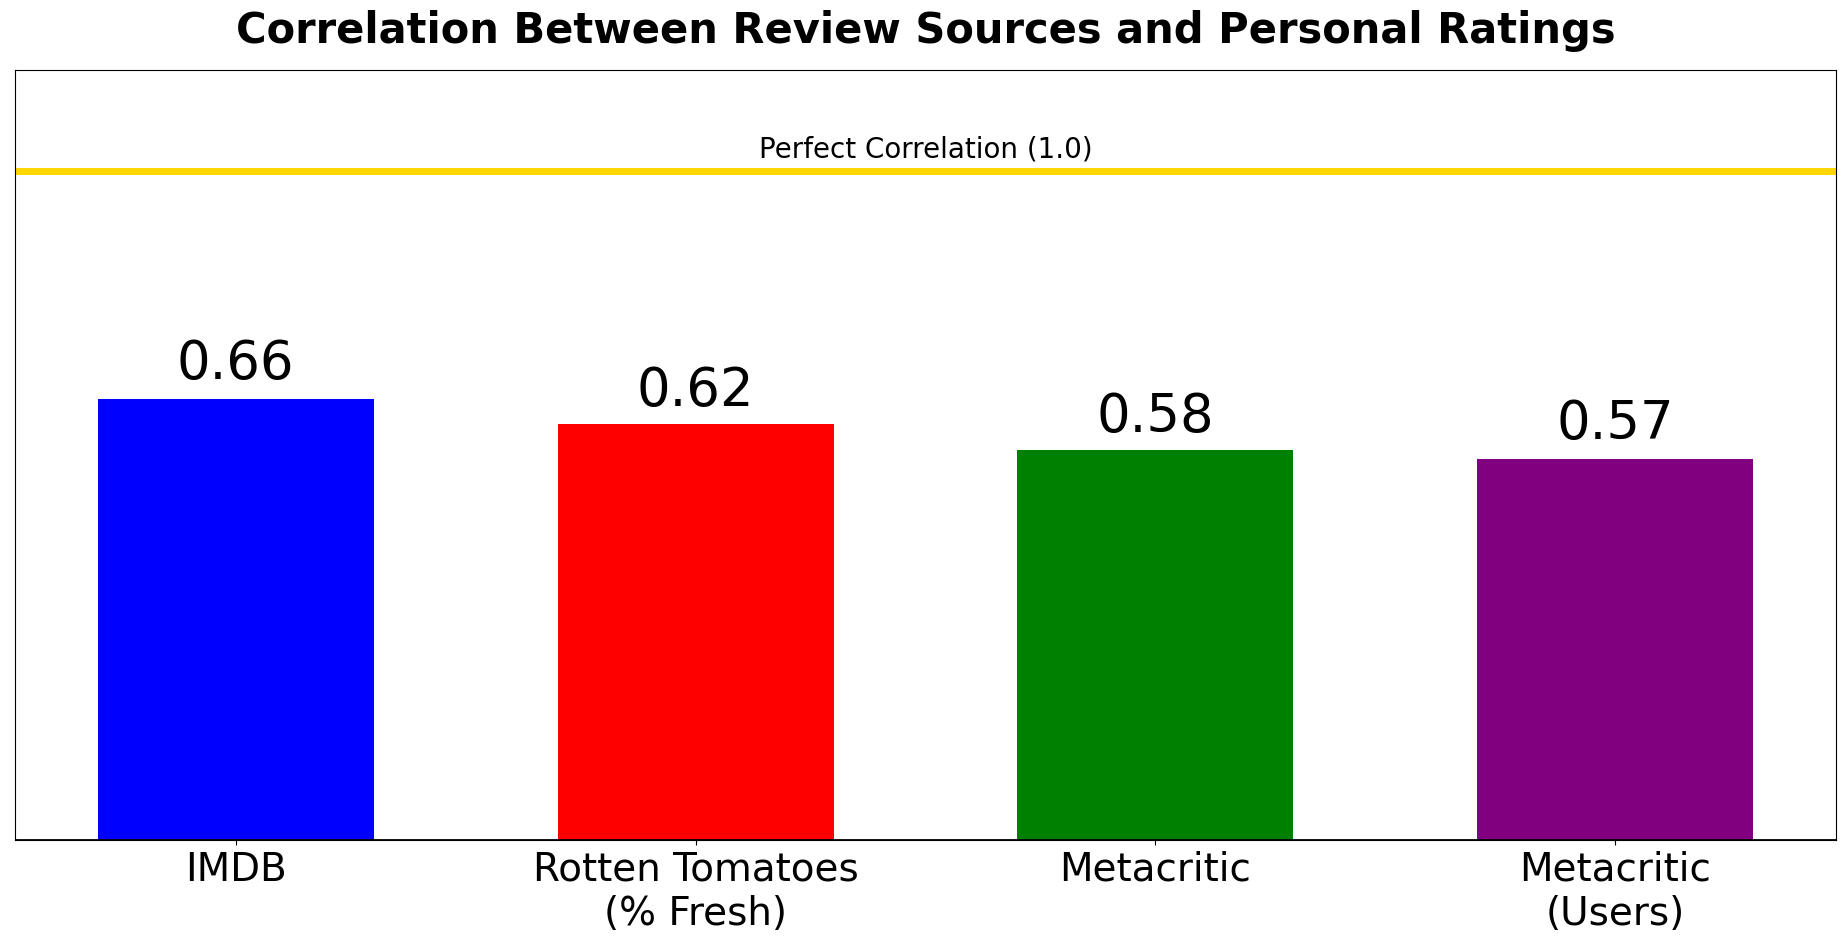

In [ ]:
### VISUALIZATION 1 ###

plt.style.use('default')

sources = scores_corr.columns
scores = [scores_corr['Personal Score'][0],
          scores_corr['Personal Score'][1],
          scores_corr['Personal Score'][2],
          scores_corr['Personal Score'][3]]
position = list(range(1, 5))

color_map = cm.get_cmap('winter')

fig, ax = plt.subplots(figsize=(23.5, 10))

plt.title('Correlation Between Review Sources and Personal Ratings', size=30, pad=20, color='black', fontweight='bold')

ax.bar(position, scores, width=.6, color=['blue', 'red', 'green', 'purple'])

plt.plot(1, 4)

plt.axhline(y=0, color='black', lw=2)
plt.axhline(y=1, color='gold', lw=5)

ax.text(position[3], round(scores[3], 2)+.03, s=round(scores[3], 2), ha='center', size=38, color='black')
ax.text(position[2], round(scores[2], 2)+.03, s=round(scores[2], 2), ha='center', size=38, color='black')
ax.text(position[1], round(scores[1], 2)+.03, s=round(scores[1], 2), ha='center', size=38, color='black')
ax.text(position[0], round(scores[0], 2)+.03, s=round(scores[0], 2), ha='center', size=38, color='black')

ax.text(2.5, 1.02, s='Perfect Correlation (1.0)', size=20, color='black', ha='center')

ax.set_ylim(bottom=0, top=1.15)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks(position)
ax.set_xticklabels(sources, size=28, color='black')

plt.show()

And now I know:

*My movie ratings correlate most with IMDB's. Though, that correlation isn't very high.*


---



# Let's look at this another way

# Visualization 2

*DISTRIBUTIONS!*

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


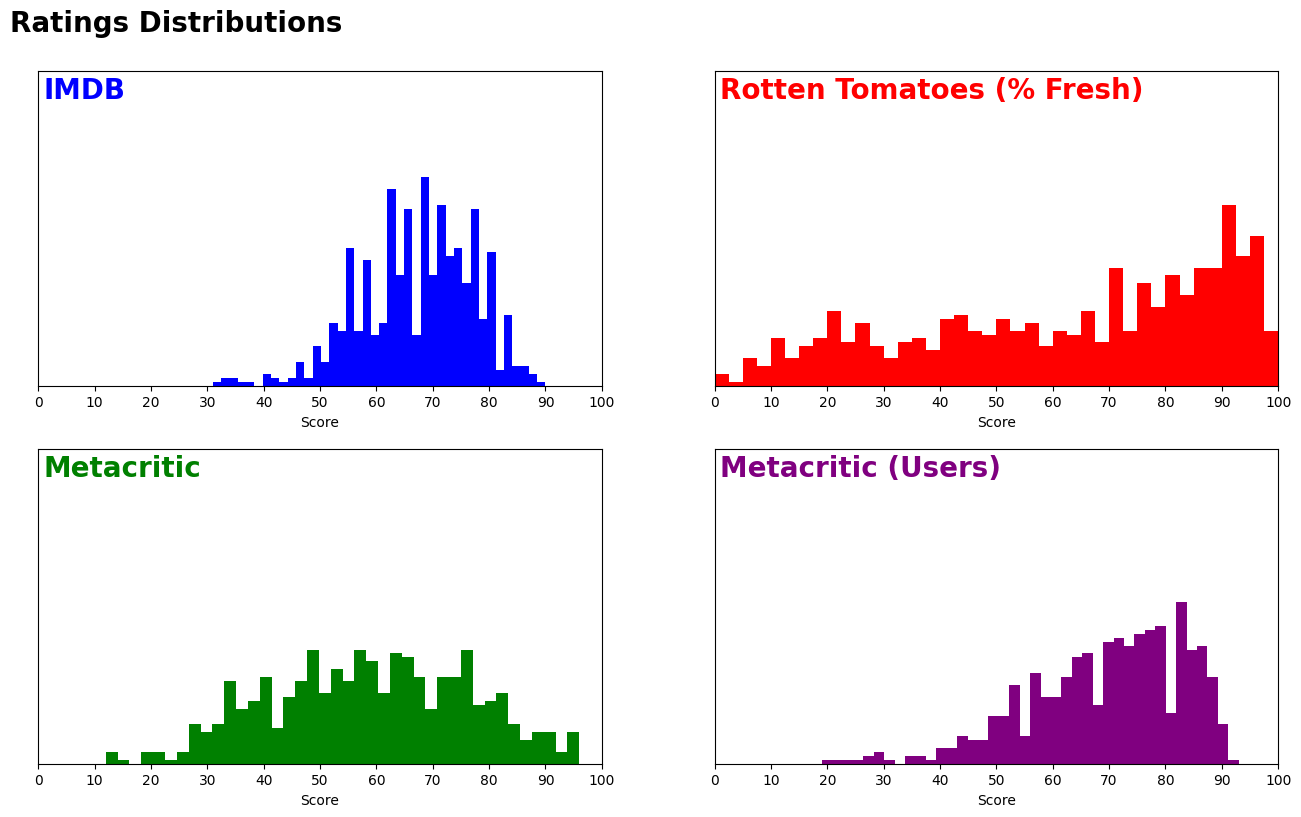

In [ ]:
### four little distributions ###

fig, ax = plt.subplots(2, 2, figsize=(16, 9))

ax[0, 0].text(-5, 90, s='Ratings Distributions', ha='left', size=20, fontweight='bold')

bins = 40

# (IMDB)
ax[0, 0].hist(bfdf['IMDB'], bins=bins, color='blue')
ax[0, 0].text(1, 75, s='IMDB', size=20, fontweight='bold', color='blue', va='center')
ax[0, 0].set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax[0, 0].set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax[0, 0].set_xlim(0,100)
ax[0, 0].set_ylim(0,80)


# (Rotten Tomatoes)
ax[0, 1].hist(bfdf['Rotten Tomatoes\n(% Fresh)'], bins=bins, color='red')
ax[0, 1].text(1, 75, s='Rotten Tomatoes (% Fresh)', size=20, fontweight='bold', color='red', va='center')
ax[0, 1].set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax[0, 1].set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax[0, 1].set_xlim(0,100)
ax[0, 1].set_ylim(0,80)


# (Metacritic)
ax[1, 0].hist(bfdf['Metacritic'], bins=bins, color='green')
ax[1, 0].text(1, 75, s='Metacritic', size=20, fontweight='bold', color='green', va='center')
ax[1, 0].set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax[1, 0].set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax[1, 0].set_xlim(0,100)
ax[1, 0].set_ylim(0,80)


# (Metacritic Users)
ax[1, 1].hist(bfdf['Metacritic\n(Users)'], bins=bins, color='purple')
ax[1, 1].text(1, 75, s='Metacritic (Users)', size=20, fontweight='bold', color='purple', va='center')
ax[1, 1].set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax[1, 1].set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax[1, 1].set_xlim(0,100)
ax[1, 1].set_ylim(0,80)


for a in ax.flat:
    a.set_yticklabels([])
    a.set_yticks([])
    a.set_xlabel('Score')


plt.show()

*oh yeah*

*beautiful*

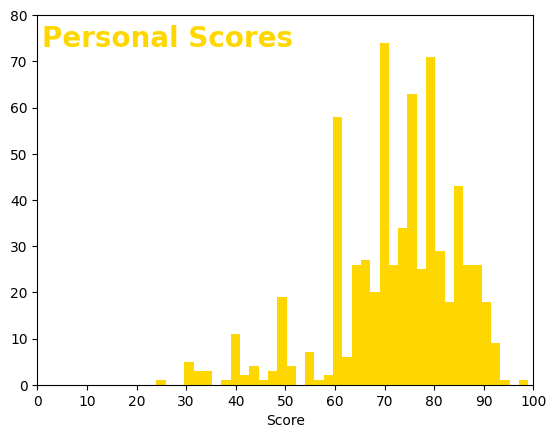

In [ ]:
### personal distribution ###

fig, ax = plt.subplots()

ax.hist(bfdf['Personal Score'], bins=40, color='gold')
ax.text(1, 75, s='Personal Scores', size=20, fontweight='bold', color='gold', va='center')
ax.set_xlim(0,100)
ax.set_ylim(0,80)
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax.set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax.set_xlabel('Score')
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

plt.show()

*The greatest insight I've gathered from these distributions is that I really liked picking multiples of 10 and 5 when I reviewed these 668 movies.*

*Here are those 4 tallest peaks:*

In [ ]:
dist = pd.DataFrame(bfdf['Personal Score'].value_counts()).reset_index()
dist.columns = ['Score', '# of movies']
dist = dist.sort_values(by=['# of movies'], ascending=False)
dist.head(4)

,Score,# of movies
0,70.0,58
1,80.0,55
2,75.0,48
3,60.0,47


# Bonus Visualization

*I tried many different visualizations on this data and most of them ended up in hell.*

*But for whatever reason, I kept this one around.*

*good thing, too! I ended up using this viz in my blog post*

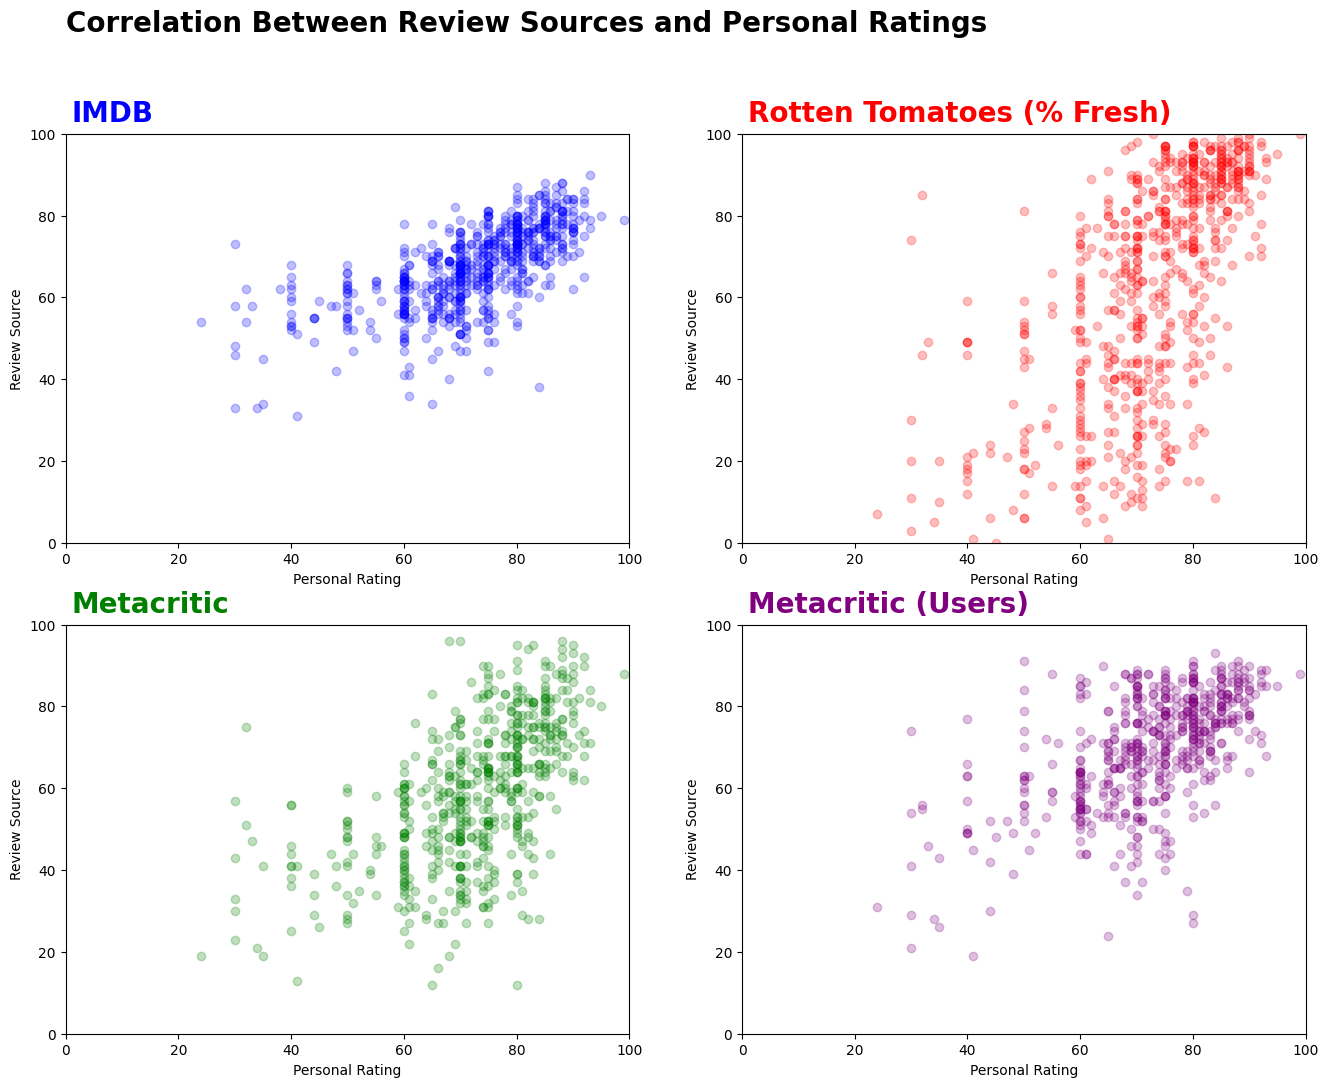

In [ ]:
### nah this is lame ### or is it

fig, ax = plt.subplots(2, 2, figsize=(16, 9))

ax[0, 0].text(0, 125, s='Correlation Between Review Sources and Personal Ratings', ha='left', size=20, fontweight='bold')

# top left (IMDB)
ax[0, 0].scatter(bfdf['Personal Score'], bfdf['IMDB'], color='blue', alpha=0.25)
ax[0, 0].text(1, 103, s='IMDB', size=20, fontweight='bold', color='blue')
ax[0, 0].set_xlim(0,100)
ax[0, 0].set_ylim(0,100)

# top right (Rotten Tomatoes)
ax[0, 1].scatter(bfdf['Personal Score'], bfdf['Rotten Tomatoes\n(% Fresh)'], color='red', alpha=0.25)
ax[0, 1].text(1, 103, s='Rotten Tomatoes (% Fresh)', size=20, fontweight='bold', color='red')
ax[0, 1].set_xlim(0,100)
ax[0, 1].set_ylim(0,100)

# bottom left (Metacritic)
ax[1, 0].scatter(bfdf['Personal Score'], bfdf['Metacritic'], color='green', alpha=0.25)
ax[1, 0].text(1, 103, s='Metacritic', size=20, fontweight='bold', color='green')
ax[1, 0].set_xlim(0,100)
ax[1, 0].set_ylim(0,100)

# bottom right (Metacritic Users)
ax[1, 1].scatter(bfdf['Personal Score'], bfdf['Metacritic\n(Users)'], color='purple', alpha=0.25)
ax[1, 1].text(1, 103, s='Metacritic (Users)', size=20, fontweight='bold', color='purple')
ax[1, 1].set_xlim(0,100)
ax[1, 1].set_ylim(0,100)

for a in ax.flat:
    a.set_xlabel('Personal Rating')

for a in ax.flat:
    a.set_ylabel('Review Source')

plt.subplots_adjust(bottom=6, top=7)

plt.show()

In [ ]:
bfdf.sort_values(by='Personal Score')

,IMDB ID,Type,Title,Year,Genres,IMDB,Metacritic,Metacritic\n(Users),Rotten Tomatoes\n(% Fresh),Personal Score,Worth Watching?
471,tt2191701,movie,Grown Ups 2,2013,Comedy,54.0,19.0,31.0,7.0,24.0,0
491,tt1951261,movie,The Hangover Part III,2013,"Comedy,Crime",58.0,30.0,54.0,20.0,30.0,0
435,tt1446192,movie,Rise of the Guardians,2012,"Action,Adventure,Animation",73.0,57.0,74.0,74.0,30.0,0
150,tt0255798,movie,The Animal,2001,"Comedy,Sci-Fi",48.0,43.0,41.0,30.0,30.0,0
406,tt0810913,movie,Jack and Jill,2011,Comedy,33.0,23.0,21.0,3.0,30.0,0
...,...,...,...,...,...,...,...,...,...,...,...
381,tt0398286,movie,Tangled,2010,"Adventure,Animation,Comedy",77.0,71.0,85.0,89.0,93.0,1
340,tt0468569,movie,The Dark Knight,2008,"Action,Crime,Drama",90.0,84.0,89.0,94.0,93.0,1
546,tt2488496,movie,Star Wars: Episode VII - The Force Awakens,2015,"Action,Adventure,Sci-Fi",79.0,81.0,68.0,93.0,93.0,1
281,tt0381061,movie,Casino Royale,2006,"Action,Adventure,Thriller",80.0,80.0,85.0,95.0,95.0,1
